### Prepare Workspace

In [1]:
# Import system libraries
import os
import sys

# Import data cleaning libraries
import pandas as pd
import numpy as np
import calendar
from datetime import datetime

# Import machine learning libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
import shap

# Import data visualisation libraries
import matplotlib.pyplot as plt 

# Import warning libraries
import warnings
warnings.filterwarnings("ignore")

# Set working directory
os.chdir('/Users/jessicarapson/Documents/GitHub/crop-yield-estimate/')
sys.path.insert(0, '/Users/jessicarapson/Documents/GitHub/crop-yield-estimate/pipeline')

# Import preprocessing libraries
from preprocessing import cleaning
from preprocessing import feature_engineering
from preprocessing import scaling
from preprocessing import feature_selection
from preprocessing import dim_reduction
from preprocessing import clustering

# Preprocess data
train_path = "data/Train.csv"
test_path = "data/Test.csv"
df = cleaning.clean_data(train_path, test_path)
df = feature_engineering.get_features(df)
df = scaling.scale_features(df)
df = feature_selection.select_features(df)
df = dim_reduction.reduce_dim(df)
df = clustering.get_clusters(df)

# Add error predictions
errors = pd.read_csv("pipeline/support_models/Error_Prediction.csv")
df["Error_Prediction"] = errors["Error_Prediction"]

# Add block predictions
block = pd.read_csv("pipeline/support_models/Block_Prediction.csv")
df["Block_Prediction"] = block["Block_Prediction"]

# Add linear error predictions
linear_yield = pd.read_csv("pipeline/support_models/Linear_Yield_Prediction.csv")
df["Linear_Yield_Prediction"] = linear_yield["Linear_Yield_Prediction"]

# Split data into training and test sets
df_train = df[df['Yield'].isna() == False]
df_test = df[df['Yield'].isna() == True]

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
top_cols = ['SeedlingsPerPit','Ganaura','CropOrgFYM','NoFertilizerAppln','BasalDAP',
            'BasalUrea','2appDaysUrea','Harv_hand_rent','Residue_length',
            'TransplantingIrrigationHours_per_Acre','TransIrriCost_per_Acre',
            'CropOrgFYM_per_Acre','BasalDAP_per_Acre','BasalUrea_per_Acre','1tdUrea_per_Acre',
            'Harv_hand_rent_per_Acre','TpIrrigationCost_Imputed_per_Acre',
            'Days_bw_SowTransp_Harv','Days_bw_Harv_Thresh','NursingDate_ModeDiff',
            'TillageDate_ModeDiff','HarvestDate_ModeDiff','ThreshingDate_ModeDiff',
            'Num_LandPrepMethod','Num_CropbasalFerts','Num_TopDressFert','Latitude',
            'Longitude','CropEstMethod_LineSowingAfterTillage','Threshing_method_machine',
            'Stubble_use_plowed_in_soil','LandPrepMethod_FourWheelTracRotavator_True',
            'LandPrepMethod_WetTillagePuddling_True','NursDetFactor_PreMonsoonShowers_True',
            'NursDetFactor_LabourAvailability_True','FirstTopDressFert_DAP_True',
            'HarvestMonth_November','ThreshingMonth_January','Block_Chehrakala',
            'PCropSolidOrgFertAppMethod_Broadcasting','PCropSolidOrgFertAppMethod_SoilApplied',
            'MineralFertAppMethod_1_Broadcasting','MineralFertAppMethod_1_SoilApplied','PC4',
            'PC10','PC21','top_shapley_k2_label_1']#,'Error_Prediction','Block_Prediction']#,'Linear_Yield_Prediction']

### Build Yield Generic Yield Per Acre Model With K-Fold Cross Validation

Root Mean Squared Error: 113.76354639760034


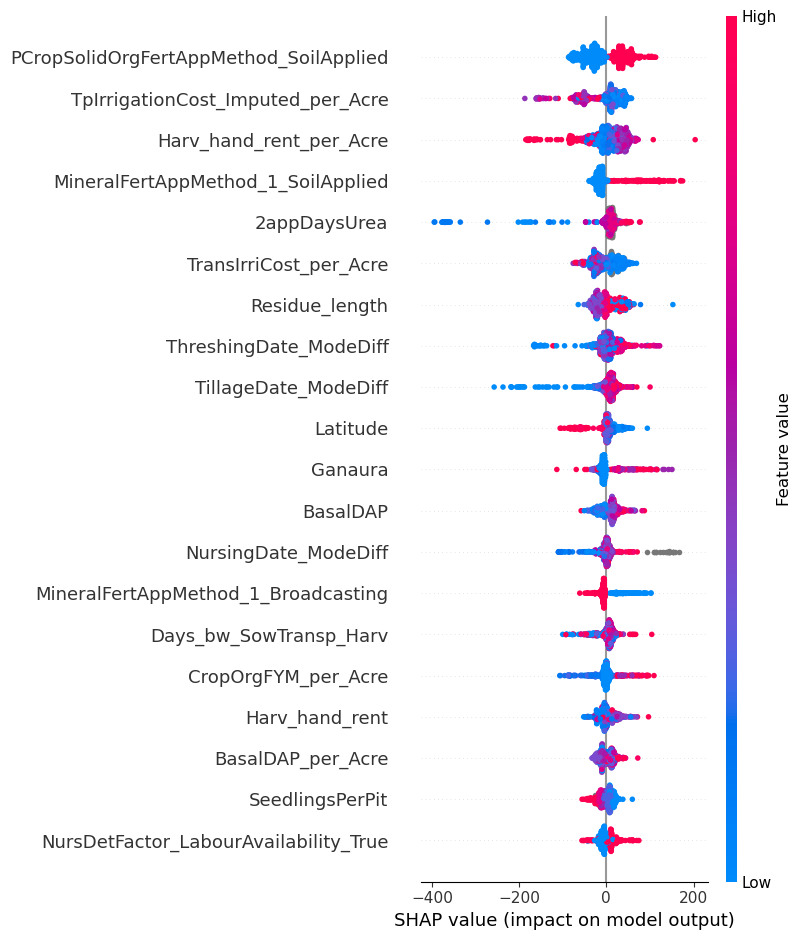

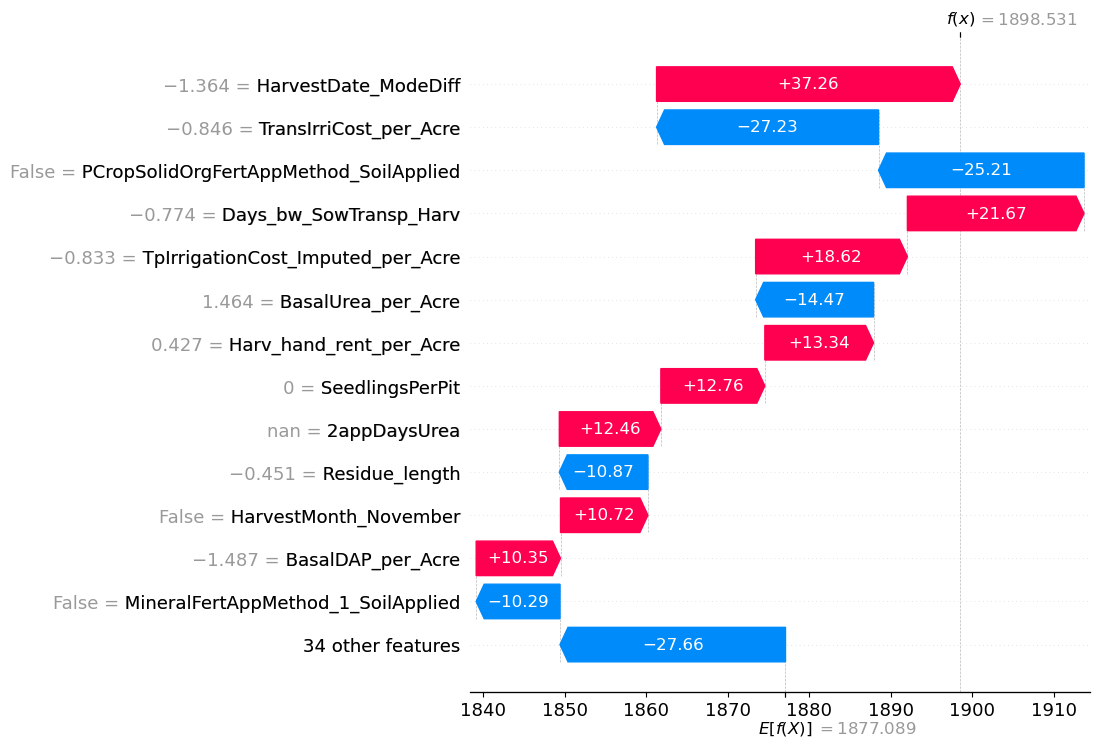

In [3]:
# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]
overfit_cols = ['Error_Prediction', 'Block_Prediction', 'Linear_Yield_Prediction']
X, y = df_train.drop(outcome_cols + overfit_cols, axis=1), df_train["New_Yield_per_Acre"]
X = X[top_cols]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an array to store fold-wise predictions
k = 5
fold_wise_predictions = np.zeros((len(y_test), k))
fold_wise_shap_values = [None] * k  # Initialize list to store SHAP values for each fold

# Define number of splits for k-fold cross-validation
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Iterate over each fold and train XGBoost model
for i, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Instantiate an XGBoost regressor model
    best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100,
                   'alpha': 0, 'lambda': 0}
    xgb_reg = xgb.XGBRegressor(**best_params, colsample_bytree=0.3)
    
    # Fit the model
    xgb_reg.fit(X_tr, y_tr)
    
    # Make predictions on the validation set
    fold_preds = xgb_reg.predict(X_test)
    
    # Fix low errors with floor value
    fold_preds = np.where(fold_preds <= 15, 15, fold_preds)
    
    # Store fold-wise predictions
    fold_wise_predictions[:, i] = fold_preds
    
    # Create a SHAP explainer
    explainer = shap.Explainer(xgb_reg)
    
    # Calculate SHAP values for the validation set of this fold
    shap_values = explainer.shap_values(X_test)
    
    # Store fold-wise SHAP values
    fold_wise_shap_values[i] = shap_values

# Calculate the average of predictions from each fold for each row
final_predictions = np.mean(fold_wise_predictions, axis=1)

# Calculate the maximum number of rows among the fold-wise SHAP arrays
max_rows = max([shap_values.shape[0] for shap_values in fold_wise_shap_values])
# Pad and stack the fold-wise SHAP arrays to make them the same size
padded_shap_values = [
    np.pad(shap_values, ((0, max_rows - shap_values.shape[0]), (0, 0)), mode='constant', constant_values=np.nan)
    for shap_values in fold_wise_shap_values
]
stacked_shap_values = np.stack(padded_shap_values)

# Compute the mean of SHAP values across folds, ignoring NaN values
mean_shap_values = np.nanmean(stacked_shap_values, axis=0)

# Evaluate the model using RMSE (Root Mean Squared Error)
indices = list(y_test.index)
rmse = mean_squared_error(df_train.loc[indices]["New_Yield"],
                          final_predictions * df_train.loc[indices]["Acre"], squared=False)
print("Root Mean Squared Error:", rmse)

# Summary plot of Shapleys values
shap.summary_plot(mean_shap_values, X_test)

# Explain one specific prediction
sample_index = 21
shap_values = explainer(X)
shap.plots.waterfall(shap_values[sample_index], max_display=14)

### Create Predictions Using K-Fold Training for the Entire Dataset

In [4]:
# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]
overfit_cols = ['Error_Prediction', 'Block_Prediction', 'Linear_Yield_Prediction']
X, y = df_train.drop(outcome_cols + overfit_cols, axis=1), df_train["New_Yield_per_Acre"]
X = X[top_cols]

# Initialize an array to store fold-wise predictions
k = 5
fold_wise_predictions = np.zeros((len(df_test), k))

# Define number of splits for k-fold cross-validation
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Iterate over each fold and train XGBoost model
for i, (train_idx, val_idx) in enumerate(kfold.split(X)):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Instantiate an XGBoost regressor model
    best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100,
                   'alpha': 0, 'lambda': 0}
    xgb_reg = xgb.XGBRegressor(**best_params, colsample_bytree=0.3)
    
    # Fit the model
    xgb_reg.fit(X_tr, y_tr)
    
    # Make predictions
    test_predictors = df_test.drop(outcome_cols + overfit_cols, axis=1)[top_cols]
    test_folds_pred = xgb_reg.predict(test_predictors) * df_test["Acre"]
    
    # Store fold-wise predictions
    fold_wise_predictions[:, i] = test_folds_pred

# Calculate the average of predictions from each fold for each row
final_predictions = np.mean(fold_wise_predictions, axis=1)

# Add predictions to sample submission file
df_test_pred = pd.read_csv("data/SampleSubmission.csv")
df_test_pred['Yield'] = final_predictions
df_test_pred['Yield'] = np.where(df_test_pred['ID'] == 'ID_PMSOXFT4FYDW',
                                 df_test_pred['Yield'] * 10, df_test_pred['Yield'])

# Choose a floor value
df_test_pred['Yield'] = np.where(df_test_pred['Yield'] <= 4, 4, df_test_pred['Yield'])

# Export submission
df_test_pred.to_csv('submission/Submission.csv', index=False)

print("---Predictions made---")

---Predictions made---


### Build Yield Generic Yield Per Acre Model

Root Mean Squared Error: 112.1339788604813


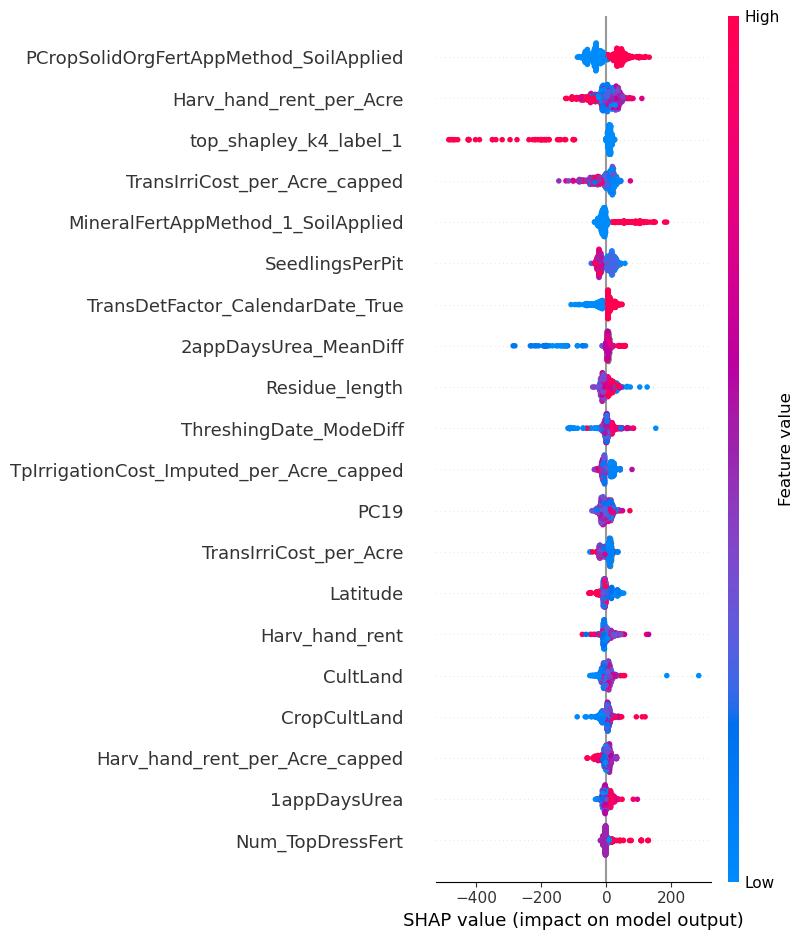

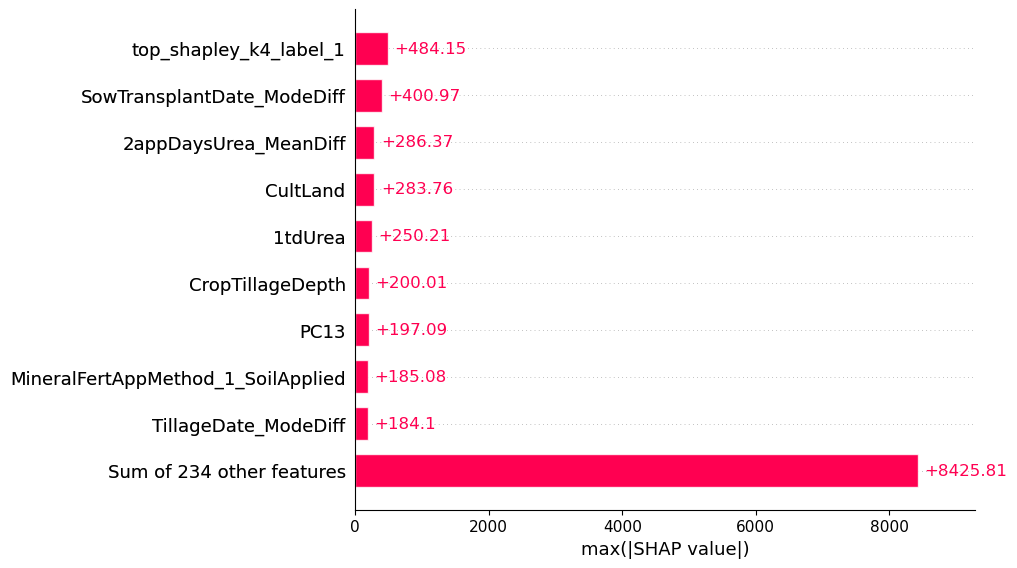

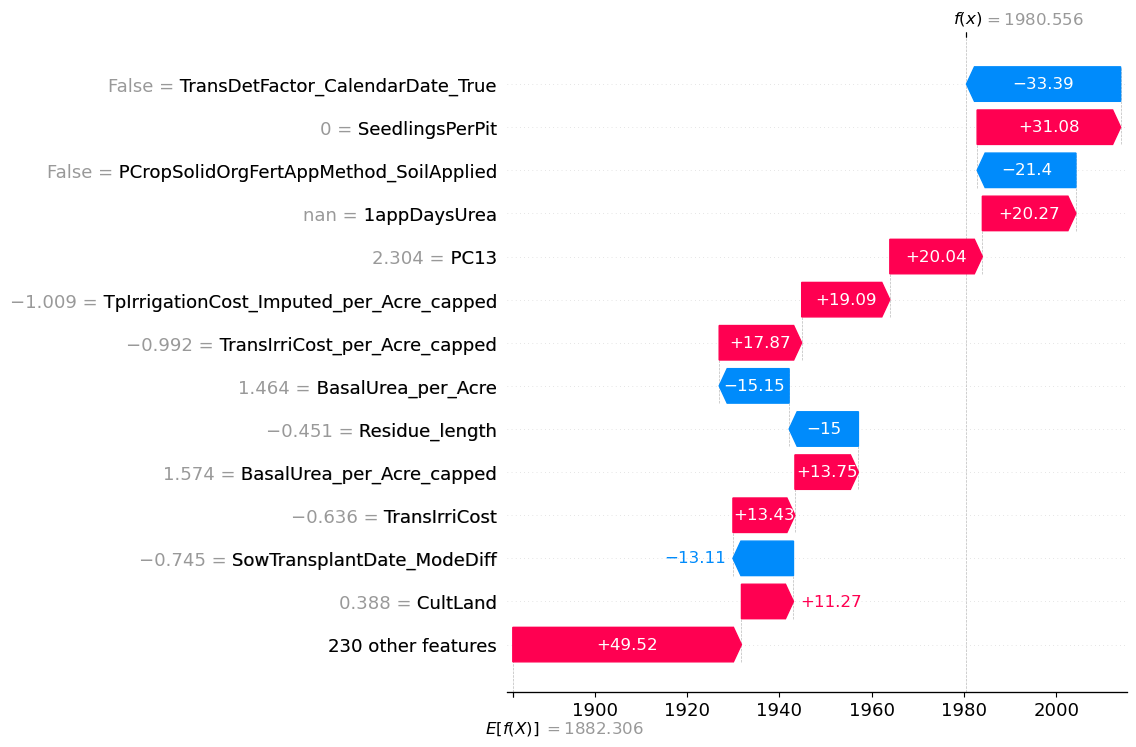

In [224]:
# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]
overfit_cols = ['Error_Prediction', 'Block_Prediction', 'Linear_Yield_Prediction']
X, y = df_train.drop(outcome_cols + overfit_cols, axis=1), df_train["New_Yield_per_Acre"]
#X = X[top_cols]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate an XGBoost regressor model
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100,
               'alpha': 0, 'lambda': 0}
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3,
                         **best_params)

# Train the XGBoost model
xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)

# Evaluate the model using RMSE (Root Mean Squared Error)
indices = list(y_test.index)
rmse = mean_squared_error(df_train.loc[indices]["New_Yield"],
                          y_pred * df_train.loc[indices]["Acre"], squared=False)
print("Root Mean Squared Error:", rmse)

# Create a TreeExplainer object with the XGBoost model
explainer = shap.TreeExplainer(xg_reg)

# Calculate Shapley values for a specific sample (replace index with your desired sample index)
shap_values = explainer.shap_values(X_test)

# Summary plot of Shapleys values
shap.summary_plot(shap_values, X_test)
shap.plots.bar(explainer(X_test).abs.max(0))

# Explain one specific prediction
sample_index = 21
shap_values = explainer(X)
shap.plots.waterfall(shap_values[sample_index], max_display=14)

### Make Predictions

In [71]:
# Retrain model on entire training data
xg_reg.fit(X, y)
print("---Training complete---")

---Training complete---


In [72]:
# Make predictions
test_predictors = df_test.drop(outcome_cols, axis=1)[top_cols]
test_pred = xg_reg.predict(test_predictors) * df_test["Acre"]

# Add predictions to sample submission file
df_test_pred = pd.read_csv("data/SampleSubmission.csv")
df_test_pred['Yield'] = test_pred
df_test_pred['Yield'] = np.where(df_test_pred['ID'] == 'ID_PMSOXFT4FYDW',
                                 df_test_pred['Yield'] * 10, df_test_pred['Yield'])

# Export submission
df_test_pred.to_csv('submission/Submission.csv', index=False)

print("---Predictions made---")

---Predictions made---


### Test Ideas

### Build Yield Per Acre SD Model With K-Fold Cross Validation

Root Mean Squared Error: 114.15470655170081


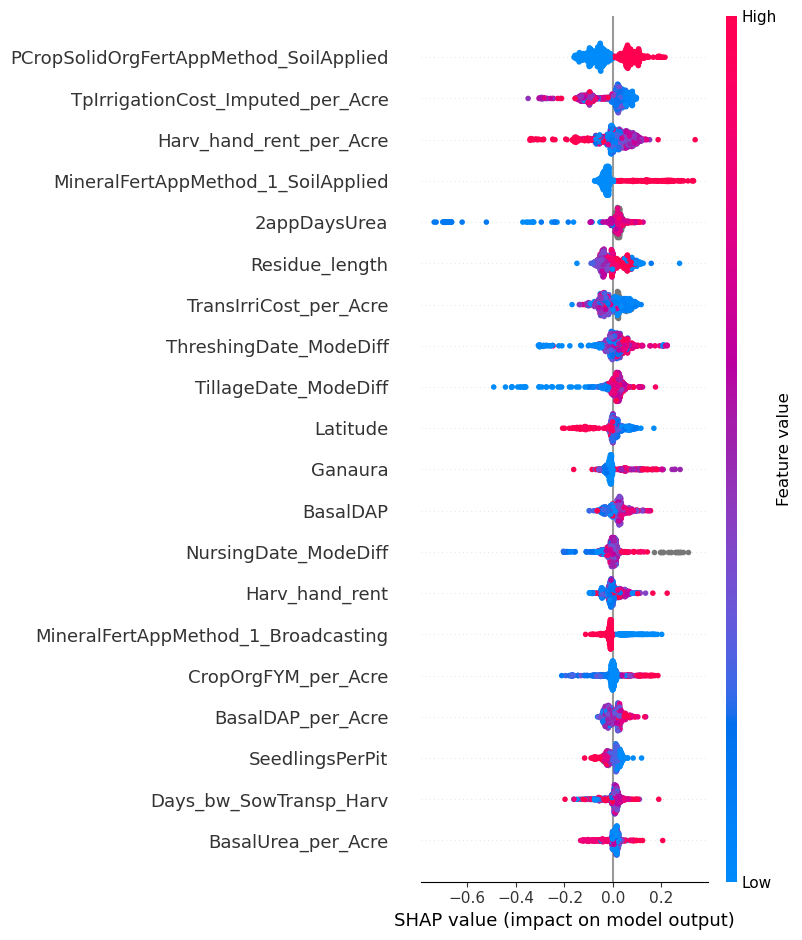

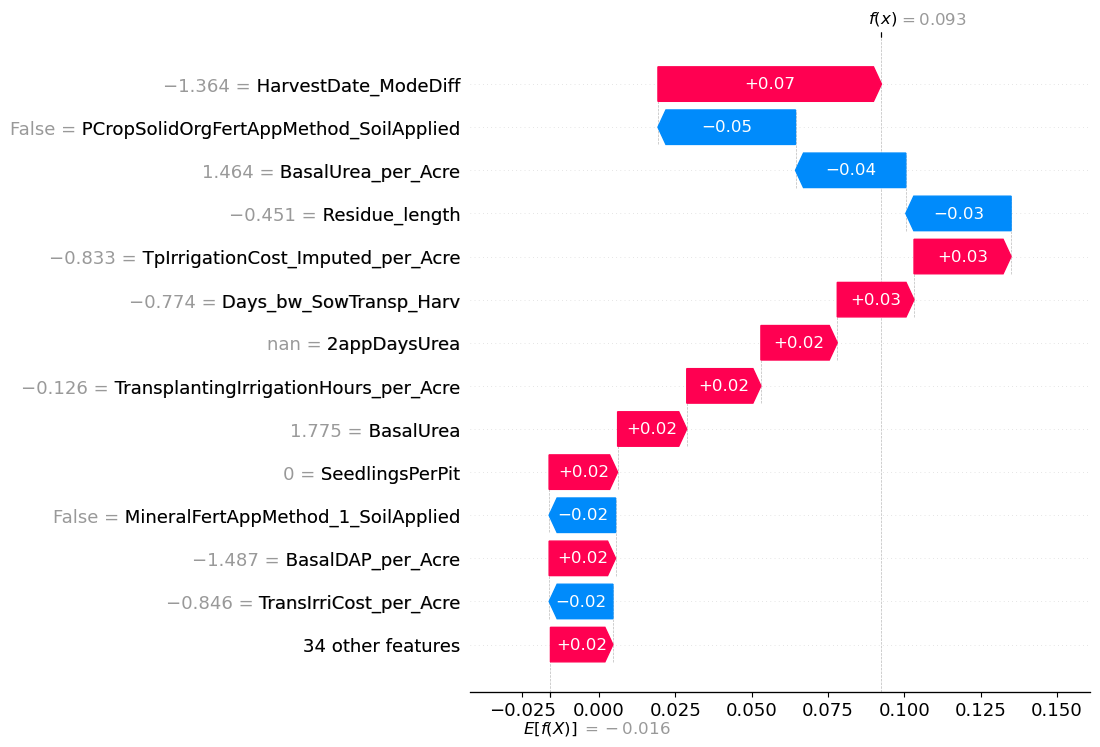

In [79]:
# Calculate standardised scores for yield per acre
mean = df_train['New_Yield_per_Acre'].mean()
std = df_train['New_Yield_per_Acre'].std()
df_train['New_Yield_per_Acre_Standardised'] = (df_train['New_Yield_per_Acre'] - mean) / std

# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre","New_Yield_per_Acre_Standardised"]
overfit_cols = ['Error_Prediction', 'Block_Prediction', 'Linear_Yield_Prediction']
X, y = df_train.drop(outcome_cols + overfit_cols, axis=1), df_train["New_Yield_per_Acre_Standardised"]
X = X[top_cols]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an array to store fold-wise predictions
k = 5
fold_wise_predictions = np.zeros((len(y_test), k))
fold_wise_shap_values = [None] * k  # Initialize list to store SHAP values for each fold

# Define number of splits for k-fold cross-validation
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Iterate over each fold and train XGBoost model
for i, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Instantiate an XGBoost regressor model
    best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100,
                   'alpha': 0, 'lambda': 0}
    xgb_reg = xgb.XGBRegressor(**best_params, colsample_bytree=0.3)
    
    # Fit the model
    xgb_reg.fit(X_tr, y_tr)
    
    # Make predictions on the validation set
    fold_preds = xgb_reg.predict(X_test) * std + mean
    
    # Fix low errors with floor value
    fold_preds = np.where(fold_preds <= 15, 15, fold_preds)
    
    # Store fold-wise predictions
    fold_wise_predictions[:, i] = fold_preds
    
    # Create a SHAP explainer
    explainer = shap.Explainer(xgb_reg)
    
    # Calculate SHAP values for the validation set of this fold
    shap_values = explainer.shap_values(X_test)
    
    # Store fold-wise SHAP values
    fold_wise_shap_values[i] = shap_values

# Calculate the average of predictions from each fold for each row
final_predictions = np.mean(fold_wise_predictions, axis=1)

# Calculate the maximum number of rows among the fold-wise SHAP arrays
max_rows = max([shap_values.shape[0] for shap_values in fold_wise_shap_values])
# Pad and stack the fold-wise SHAP arrays to make them the same size
padded_shap_values = [
    np.pad(shap_values, ((0, max_rows - shap_values.shape[0]), (0, 0)), mode='constant', constant_values=np.nan)
    for shap_values in fold_wise_shap_values
]
stacked_shap_values = np.stack(padded_shap_values)

# Compute the mean of SHAP values across folds, ignoring NaN values
mean_shap_values = np.nanmean(stacked_shap_values, axis=0)

# Evaluate the model using RMSE (Root Mean Squared Error)
indices = list(y_test.index)
rmse = mean_squared_error(df_train.loc[indices]["New_Yield"],
                          final_predictions * df_train.loc[indices]["Acre"], squared=False)
print("Root Mean Squared Error:", rmse)

# Summary plot of Shapleys values
shap.summary_plot(mean_shap_values, X_test)

# Explain one specific prediction
sample_index = 21
shap_values = explainer(X)
shap.plots.waterfall(shap_values[sample_index], max_display=14)

### Make Predictions Using Per Acre SD Model With K-Fold Cross Validation

In [89]:
# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]
overfit_cols = ['Error_Prediction', 'Block_Prediction', 'Linear_Yield_Prediction']
X, y = df_train.drop(outcome_cols + overfit_cols + ["New_Yield_per_Acre_Standardised"], axis=1), df_train["New_Yield_per_Acre_Standardised"]
X = X[top_cols]

# Initialize an array to store fold-wise predictions
k = 5
fold_wise_predictions = np.zeros((len(df_test), k))

# Define number of splits for k-fold cross-validation
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Iterate over each fold and train XGBoost model
for i, (train_idx, val_idx) in enumerate(kfold.split(X)):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Instantiate an XGBoost regressor model
    best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100,
                   'alpha': 0, 'lambda': 0}
    xgb_reg = xgb.XGBRegressor(**best_params, colsample_bytree=0.3)
    
    # Fit the model
    xgb_reg.fit(X_tr, y_tr)
    
    # Make predictions
    test_predictors = df_test.drop(outcome_cols + overfit_cols, axis=1)[top_cols]
    test_folds_pred = xgb_reg.predict(test_predictors) * std + mean * df_test["Acre"]
    
    # Store fold-wise predictions
    fold_wise_predictions[:, i] = test_folds_pred

# Calculate the average of predictions from each fold for each row
final_predictions = np.mean(fold_wise_predictions, axis=1)

# Add predictions to sample submission file
df_test_pred = pd.read_csv("data/SampleSubmission.csv")
df_test_pred['Yield'] = final_predictions
df_test_pred['Yield'] = np.where(df_test_pred['ID'] == 'ID_PMSOXFT4FYDW',
                                 df_test_pred['Yield'] * 10, df_test_pred['Yield'])

# Choose a floor value
df_test_pred['Yield'] = np.where(df_test_pred['Yield'] <= 4, 4, df_test_pred['Yield'])

# Export submission
df_test_pred.to_csv('submission/Submission.csv', index=False)

print("---Predictions made---")

---Predictions made---


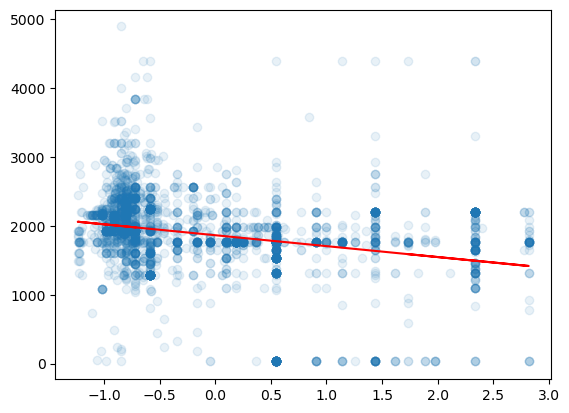

In [43]:
var = 'TransIrriCost_per_Acre_capped'

data = df_train[df_train[var].isna() == False]
slope, intercept = np.polyfit(data[var], data['New_Yield_per_Acre'], 1)

# Plot the line of best fit
plt.plot(data[var], slope * data[var] + intercept, color='red') 
plt.scatter(data[var], data['New_Yield_per_Acre'], alpha=0.1)

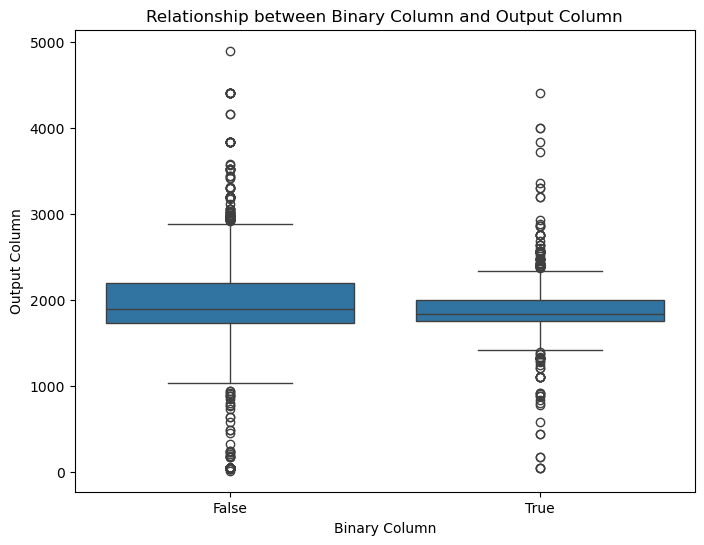

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot to visualize the relationship
plt.figure(figsize=(8, 6))
sns.boxplot(x='1appDaysUrea_NaN_True', y='New_Yield_per_Acre', data=df)
plt.xlabel('Binary Column')
plt.ylabel('Output Column')
plt.title('Relationship between Binary Column and Output Column')
plt.show()

In [3]:
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

# Calculate the mean absolute SHAP values for each feature
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# Create a DataFrame to hold the feature names and their mean absolute SHAP values
shap_df = pd.DataFrame({'Feature': X.columns, 'Mean_ABS_SHAP': mean_abs_shap})

# Sort the DataFrame by mean absolute SHAP values in descending order
shap_df_sorted = shap_df.sort_values(by='Mean_ABS_SHAP', ascending=False)

# Extract the top n columns based on mean absolute SHAP values
n = 30
top_n_columns = shap_df_sorted.head(n)['Feature'].tolist()

top_n_columns

['Harv_hand_rent_per_Acre',
 'PCropSolidOrgFertAppMethod_SoilApplied',
 'TransIrriCost_per_Acre',
 'MineralFertAppMethod_1_SoilApplied',
 'PC4',
 'ThreshingDate_ModeDiff',
 'TpIrrigationCost_Imputed_per_Acre',
 'SeedlingsPerPit',
 'Latitude',
 'PC10',
 'HarvestDate_ModeDiff',
 'Residue_length',
 '1appDaysUrea',
 'top_shapley_k2_label_1',
 'top_shapley_k4_label_2',
 'PC21',
 '2appDaysUrea',
 'Num_LandPrepMethod',
 'TransIrriCost_per_Acre_capped',
 'PC19',
 'MineralFertAppMethod_1_Broadcasting',
 'PC3',
 'Num_TopDressFert',
 'Harv_hand_rent',
 'CultLand',
 'TillageDate_ModeDiff',
 'BasalDAP',
 'PCropSolidOrgFertAppMethod_Broadcasting',
 'Elevation',
 'PC18',
 'BasalDAP_per_Acre',
 'NursDetFactor_LabourAvailability_True',
 'PC20',
 'ThreshingMonth_January']

In [19]:
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)
top_columns = []

# Calculate the maximum absolute value of each column in the shap_values matrix
column_max_abs = np.max(np.abs(shap_values), axis=0)

# Attach maximum absolute values to column names
column_max_with_names_abs = {column: max_val for column, max_val in zip(X.columns, column_max_abs)}

# Sort the column maximum absolute values in descending order
sorted_column_max_abs = sorted(column_max_with_names_abs.items(), key=lambda x: x[1], reverse=True)

# Save all column names into a sorted array
sorted_columns = [column for column, _ in sorted_column_max_abs]

# Display top N column names with their maximum absolute values in descending order
for column, max_val in sorted_column_max_abs:
    top_columns.append(column)
    
top_cols = top_columns[:60]

# Calculate mean of each column in the shap_values matrix
column_means = np.mean(shap_values, axis=0)

# Attach mean values to column names
column_means_with_names = {column: mean for column, mean in zip(X.columns, column_means)}

# # Display column names with their mean values
# for column, mean in column_means_with_names.items():
#     print(f"{column}: {mean}")
    
# print(top_cols)

In [9]:
# Run Shaw's code


# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]

# Drop columns excluding the top features
X, y = df_train.drop(outcome_cols, axis=1), df_train["New_Yield_per_Acre"]

#X = X[top_cols]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [5],
    'n_estimators': [100],
    'alpha': [0, 0.1, 1, 10],
    'lambda': [0, 0.1, 1, 10],
}

# Instantiate an XGBoost regressor model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score from grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the XGBoost model with the best parameters
xg_reg_best = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, **best_params)
xg_reg_best.fit(X_train, y_train)

# Predict on the test set using the best model
y_pred_best = xg_reg_best.predict(X_test)

indices = list(y_test.index)


# Evaluate the best model using RMSE (Root Mean Squared Error)
rmse_best = mean_squared_error(df_train.loc[indices]["New_Yield"], y_pred_best * df_train.loc[indices]["Acre"], squared=False)
print("Best Model - Root Mean Squared Error:", rmse_best)


Best Model - Root Mean Squared Error: 63.16008440987012


In [10]:
best_params

{'alpha': 0,
 'lambda': 0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100}

In [13]:
# Train the XGBoost model with the best parameters on all the data
xg_reg_best = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, **best_params)
xg_reg_best.fit(X, y)
print("---Training complete---")

# Make predictions
test_predictors = df_test.drop(outcome_cols, axis=1)#[top_cols]
test_pred = xg_reg_best.predict(test_predictors) * df_test["Acre"]

# Add predictions to sample submission file
df_test_pred = pd.read_csv("data/SampleSubmission.csv")
df_test_pred['Yield'] = test_pred
df_test_pred['Yield'] = np.where(df_test_pred['ID'] == 'ID_PMSOXFT4FYDW',
                                 df_test_pred['Yield'] * 10, df_test_pred['Yield'])

# Export submission
df_test_pred.to_csv('submission/Submission.csv', index=False)

print("---Predictions made---")

---Training complete---
---Predictions made---


In [14]:
# Predict on the test set using the best model
y_pred_best = xg_reg_best.predict(X)
mean_squared_error(df_train["New_Yield"], y_pred_best * df_train["Acre"], squared=False)

22.18381055280325

In [15]:
#### PERFORM RECURSIVE FEATURE ELIMINATION WITH CROSS VALIDATION

from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]
X, y = df_train.drop(outcome_cols, axis=1), df_train["New_Yield_per_Acre"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost regressor
xgb_reg = XGBRegressor()

# Initialize RFECV with XGBoost as estimator
selector = RFECV(estimator=xgb_reg, step=1, cv=5)

# Fit RFECV on the training data
selector = selector.fit(X_train, y_train)

# Get the selected features using the boolean mask
selected_feature_indices = selector.support_
selected_features = X_train.columns[selected_feature_indices].tolist()

# Train XGBoost on the selected features
xgb_reg.fit(X_train[selected_features], y_train)

# Evaluate the model on the test set
xgb_reg.score(X_test[selected_features].values, y_test)

0.7409820492596906

In [16]:
# Predict on the test set
y_pred = xgb_reg.predict(X_test[selected_features])

# Evaluate the model using RMSE (Root Mean Squared Error)
indices = list(y_test.index)
rmse = mean_squared_error(df_train.loc[indices]["New_Yield"],
                          y_pred * df_train.loc[indices]["Acre"], squared=False)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 89.10011525876243


In [17]:
selected_features

#0.8814105138717924
#Root Mean Squared Error: 58.52025672870439

['Acre',
 'CropEstMethod_LineSowingAfterTillage',
 'LandPrepMethod_FourWheelTracRotavator_True',
 'NursDetFactor_LabourAvailability_True',
 'FirstTopDressFert_DAP_True',
 'Block_Chehrakala',
 'PCropSolidOrgFertAppMethod_SoilApplied',
 'Error_Prediction',
 'Linear_Yield_Prediction']

In [31]:
### Add prediction for degree of under or over-estimate


In [ ]:
### Plot yield per acre outliers and develop model that oversamples under-preforming yield

In [ ]:
### Add mean encoding

In [69]:
df['Yield_per_Acre'].value_counts()

Yield_per_Acre
1760.000000    255
1760.000000    251
1920.000000    226
1280.000000     99
1600.000000     92
              ... 
1749.600000      1
2944.000000      1
1350.000000      1
2327.272727      1
2089.600000      1
Name: count, Length: 598, dtype: int64

In [72]:
df[(df['Yield_per_Acre'] >= 1919) & (df['Yield_per_Acre'] <= 1921)]

,CultLand,CropCultLand,CropTillageDepth,SeedlingsPerPit,TransplantingIrrigationHours,TransIrriCost,StandingWater,Ganaura,CropOrgFYM,NoFertilizerAppln,...,top_shapley_k3_label_1,top_shapley_k3_label_2,top_shapley_k4_label_1,top_shapley_k4_label_2,top_shapley_k4_label_3,top_shapley_k5_label_1,top_shapley_k5_label_2,top_shapley_k5_label_3,top_shapley_k5_label_4,Error_Prediction
0,0.560165,0.560362,0.571429,0.047619,-0.096048,-0.443788,0.052632,-0.146433,-0.101615,0.333333,...,False,True,False,False,False,False,False,False,True,0.130194
1,-0.092617,0.039792,0.571429,0.047619,-0.096048,-0.623574,0.105263,-0.146433,-0.101615,0.333333,...,False,True,False,False,False,False,False,False,True,0.715310
9,-0.298759,-0.555145,0.571429,0.095238,-0.203921,-0.683502,0.000000,-0.146433,-0.101615,0.333333,...,False,True,False,False,False,False,False,False,True,-0.130997
19,0.388380,0.560362,0.714286,0.000000,-0.096048,-0.443788,0.052632,0.183780,-0.101615,0.333333,...,False,True,False,False,False,False,False,False,True,-0.630105
21,0.388380,0.374444,0.571429,0.000000,-0.060091,-0.635559,0.105263,-0.146433,-0.101615,0.000000,...,False,True,False,False,False,False,False,False,True,0.061259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3755,-0.298759,-0.183309,0.428571,0.000000,-0.132006,-0.395845,0.052632,-0.146433,-0.101615,0.000000,...,False,True,False,False,False,False,False,False,True,-0.276208
3766,0.388380,0.374444,0.571429,0.000000,-0.132006,-0.443788,0.210526,0.012069,-0.101615,0.333333,...,False,True,False,False,False,False,False,False,True,-0.666792
3777,0.388380,0.560362,0.714286,0.000000,-0.132006,-0.503716,0.052632,-0.146433,-0.003071,0.333333,...,True,False,False,False,False,False,False,False,True,-0.650579
3813,-0.367473,-0.257676,0.571429,0.047619,-0.096048,-0.623574,0.157895,-0.133224,-0.101615,0.333333,...,False,True,False,False,False,False,False,False,True,-0.346081


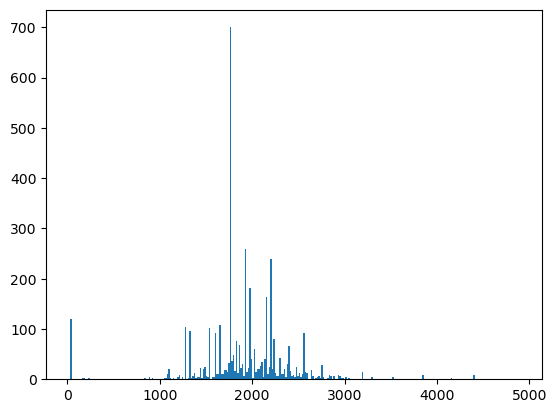

In [62]:
plt.hist(df['New_Yield_per_Acre'], bins = 300)
plt.show()

### Build Re-Sampled Model to Detect Extreme Yields

In [60]:
# Calculate standardised scores for yield per acre
df_train['New_Yield_per_Acre_Standardised'] = (df_train['New_Yield_per_Acre'] - df_train['New_Yield_per_Acre'].mean()) / df_train['New_Yield_per_Acre'].std()

from imblearn.over_sampling import SMOTE

# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield_per_Acre"]
overfit_cols = ['Error_Prediction', 'Block_Prediction', 'Linear_Yield_Prediction']
X, y = df_train.drop(outcome_cols, axis=1), df_train["New_Yield_per_Acre_Standardised"]
X = X.dropna(axis=1)
#X = X[top_cols]

# Determine the indices of extreme values
extreme_indices = np.where(df_train['New_Yield_per_Acre_Standardised'] <= -3)[0]

# Create a binary classification problem where 1 indicates extreme values
y_binary = np.where(df_train['New_Yield_per_Acre_Standardised'] <= -3, 1, 0)

# Apply SMOTE to the binary classification problem
smote = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X.drop("New_Yield_per_Acre_Standardised", axis=1), y_binary)
X_resampled, y_resampled = X_resampled.drop(['New_Yield'], axis=1), X_resampled['New_Yield'] * X_resampled['Acre']

# Create new dataframe
df_resampled = X_resampled.copy()
df_resampled['New_Yield'] = y_resampled

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
#X = X[top_cols]

# Initialize an array to store fold-wise predictions
k = 5
fold_wise_predictions = np.zeros((len(y_test), k))
fold_wise_shap_values = [None] * k  # Initialize list to store SHAP values for each fold

# Define number of splits for k-fold cross-validation
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Iterate over each fold and train XGBoost model
for i, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Instantiate an XGBoost regressor model
    best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100,
                   'alpha': 0, 'lambda': 0}
    xgb_reg = xgb.XGBRegressor(**best_params, colsample_bytree=0.3)
    
    # Fit the model
    xgb_reg.fit(X_tr, y_tr)
    
    # Make predictions on the validation set
    fold_preds = xgb_reg.predict(X_test)
    
    # Fix low errors with floor value
    fold_preds = np.where(fold_preds <= 15, 15, fold_preds)
    
    # Store fold-wise predictions
    fold_wise_predictions[:, i] = fold_preds
    
    # Create a SHAP explainer
    explainer = shap.Explainer(xgb_reg)
    
    # Calculate SHAP values for the validation set of this fold
    shap_values = explainer.shap_values(X_test)
    
    # Store fold-wise SHAP values
    fold_wise_shap_values[i] = shap_values

# Calculate the average of predictions from each fold for each row
final_predictions = np.mean(fold_wise_predictions, axis=1)

# Calculate the maximum number of rows among the fold-wise SHAP arrays
max_rows = max([shap_values.shape[0] for shap_values in fold_wise_shap_values])
# Pad and stack the fold-wise SHAP arrays to make them the same size
padded_shap_values = [
    np.pad(shap_values, ((0, max_rows - shap_values.shape[0]), (0, 0)), mode='constant', constant_values=np.nan)
    for shap_values in fold_wise_shap_values
]
stacked_shap_values = np.stack(padded_shap_values)

# Compute the mean of SHAP values across folds, ignoring NaN values
mean_shap_values = np.nanmean(stacked_shap_values, axis=0)

# Evaluate the model using RMSE (Root Mean Squared Error)
indices = list(y_test.index)
rmse = mean_squared_error(df_resampled.loc[indices]["New_Yield"],
                          final_predictions * df_resampled.loc[indices]["Acre"], squared=False)
print("Root Mean Squared Error:", rmse)

# # Summary plot of Shapleys values
# shap.summary_plot(mean_shap_values, X_test)

# # Explain one specific prediction
# sample_index = 21
# shap_values = explainer(X)
# shap.plots.waterfall(shap_values[sample_index], max_display=14)

Root Mean Squared Error: 180.96331880151646
